<a href="https://colab.research.google.com/github/Muntasir2179/bangla-accent-classification/blob/model-testing/Accent_Classification_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries and dataset

In [1]:
!pip install resampy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 14.4 MB/s eta 0:00:00


In [2]:
# data visualization libraries
import resampy
import librosa
import pandas as pd
import os
import seaborn as sns
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# data preprocessing libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# model building libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, BatchNormalization, Dropout, Flatten, Conv2D, MaxPool2D

In [3]:
audio_dataset_path='/content/drive/MyDrive/Datasets/Bangla Accent Dataset/audio/'
metadata=pd.read_csv('/content/drive/MyDrive/Datasets/Bangla Accent Dataset/audio_trace_metadata.csv')

In [4]:
metadata = metadata.sample(frac=1, random_state=42)
metadata.head()

,file_name,folder_name,accent
135,bogura_audio_21.wav,bogura,bogura
481,kurigram_audio_52.wav,kurigram,kurigram
836,noakhali_audio_192.wav,noakhali,noakhali
1227,rajshahi_audio_11.wav,rajshahi,rajshahi
629,maymenshing_audio_118.wav,maymenshing,maymenshing


In [5]:
len(metadata)

1625

In [6]:
metadata['accent'].value_counts()

chottogram     216
noakhali       214
sylhet         193
pabna          164
rajshahi       126
maymenshing    125
barishal       114
puran dhaka    104
bogura         100
madaripur       90
kurigram        80
thakurgaon      66
shatkhira       33
Name: accent, dtype: int64

# Extracting features

In [7]:
# defining a function that can extract features from audio files
import librosa

def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=128)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)

    return mfccs_scaled_features

In [8]:
# collecting features for all the audio files
from tqdm import tqdm

extracted_features=[]

for index_num, row in tqdm(metadata.iterrows()):
  accent_label = row['accent']
  file_path = '/content/drive/MyDrive/Datasets/Bangla Accent Dataset/audio/' + str(row['folder_name']) + '/' + str(row['file_name'])
  data = features_extractor(file_path)
  extracted_features.append([data, accent_label])

1625it [16:05,  1.68it/s]


In [9]:
# converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-327.04596, 122.131065, -36.754337, 15.960765...",bogura
1,"[-331.33664, 116.16823, -31.718025, 14.8468275...",kurigram
2,"[-276.85275, 138.35664, -8.049862, 22.051075, ...",noakhali
3,"[-412.29462, 85.37698, -21.690714, 9.278193, -...",rajshahi
4,"[-300.59702, 117.44205, -21.842045, 11.30596, ...",maymenshing


In [10]:
# saving the extracted features dataframe into drive for later use
extracted_features_df.to_csv('/content/drive/MyDrive/Datasets/Bangla Accent Dataset/128_audio_features.csv')

In [11]:
# Split the dataset into independent and dependent dataset
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [12]:
X.shape, y.shape

((1625, 128), (1625,))

# Applying onehot encoding on labels

In [13]:
encoder = OneHotEncoder()
y = encoder.fit_transform(y.reshape(-1, 1)).toarray()
y

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
y.shape

(1625, 13)

In [15]:
import pickle
with open("/content/drive/MyDrive/Colab Notebooks/Accent Classification/Saved Models/onehot_encoder_accent_classification.pkl", "wb") as f:
    pickle.dump(encoder, f)

# Spliting dataset into train and test

In [16]:
# split the data to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# print the details
print("Number of training samples = ", X_train.shape[0])
print("Number of testing samples = ", X_test.shape[0])
print("Number of validation samples = ", X_valid.shape[0])

Number of training samples =  975
Number of testing samples =  325
Number of validation samples =  325


# Helper functions for plotting and evaluation

In [17]:
# function for Ploting history (also known as a loss curve or a training curve)
def plot_history(history):
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [18]:
# function to predict and generate decoded value of labels
def model_prediction(x_test, y_true, model, number_of_labels, onehot_encoder):
  y_pred = model.predict(x_test, verbose=0)
  predictions = []
  for row in y_pred:
    label = np.zeros(number_of_labels)
    label[np.argmax(row)] = 1
    label.reshape(1, -1)
    predictions.append(label.tolist())
    label = None
  y_test_decoded = onehot_encoder.inverse_transform(y_true)
  y_pred_decoded = onehot_encoder.inverse_transform(predictions)
  return y_pred_decoded, y_test_decoded

In [19]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def show_evaluation_parameters(X_test, y_test, ANN_Model, number_of_labels, encoder):
  predictions, y_test_for_eval = model_prediction(X_test, y_test, ANN_Model, number_of_labels, encoder)
  print('Accuracy score : ', accuracy_score(y_test_for_eval, predictions))
  print('Precision score: ', precision_score(y_test_for_eval, predictions, average='weighted'))
  print('Recall score   : ', recall_score(y_test_for_eval, predictions, average='weighted'))
  print('F1 Score       : ', f1_score(y_test_for_eval, predictions, average='weighted'))
  print('\n--------------------------------------------\n')
  print(classification_report(y_test_for_eval, predictions))

In [20]:
def show_confusion_matrix(X_test, y_test, ANN_Model, number_of_labels, encoder):
  predictions, y_test_for_eval = model_prediction(X_test, y_test, ANN_Model, number_of_labels, encoder)
  cm = confusion_matrix(y_test_for_eval, predictions, labels=metadata['accent'].unique())
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=metadata['accent'].unique())
  fig, ax = plt.subplots(figsize=(20,13))
  disp.plot(ax=ax)
  plt.show()

# Building ANN model

In [21]:
# Construct model
num_labels = y.shape[1]

def create_ANN_model():
  ANN_Model = Sequential()
  ANN_Model.add(Dense(1000, activation="relu", input_shape=(128,)))
  ANN_Model.add(Dropout(0.1))
  ANN_Model.add(Dense(750, activation="relu"))
  ANN_Model.add(Dropout(0.1))
  ANN_Model.add(Dense(500, activation="relu"))
  ANN_Model.add(Dropout(0.1))
  ANN_Model.add(Dense(250, activation="relu"))
  ANN_Model.add(Dropout(0.1))
  ANN_Model.add(Dense(100, activation="relu"))
  ANN_Model.add(Dropout(0.1))
  ANN_Model.add(Dense(50, activation="relu"))
  ANN_Model.add(Dropout(0.1))
  ANN_Model.add(Dense(30, activation="relu"))
  ANN_Model.add(Dense(num_labels, activation="softmax"))
  return ANN_Model

In [22]:
ANN_Model = create_ANN_model()

ANN_Model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0009),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

In [24]:
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint

class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_accuracy') > 0.91:
      self.model.stop_training = True

custom_callback = MyCallback()

def lr_scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

scheduler_callback = LearningRateScheduler(lr_scheduler)

ckeckpoint_path = '/content/drive/MyDrive/Colab Notebooks/Accent Classification/Saved Models/model checkpoints'

checkpoint_callback = ModelCheckpoint(filepath = ckeckpoint_path,
                                      monitor = 'val_accuracy',
                                      verbose = 0,
                                      save_best_only = True,
                                      save_weights_only = False,
                                      mode = 'max',
                                      save_freq = 'epoch')

In [25]:
num_epochs = 150
num_batch_size = 5

ANN_Results = ANN_Model.fit(X_train,
                            y_train,
                            batch_size=num_batch_size,
                            epochs=num_epochs,
                            validation_data=(X_test, y_test),
                            callbacks=[checkpoint_callback]
                            )

Epoch 1/150
195/195 [==============================] - 12s 16ms/step - loss: 3.1861 - accuracy: 0.1179 - val_loss: 2.5569 - val_accuracy: 0.0523
Epoch 2/150
195/195 [==============================] - 2s 12ms/step - loss: 2.5480 - accuracy: 0.1333 - val_loss: 2.4667 - val_accuracy: 0.1292
Epoch 3/150
195/195 [==============================] - 2s 12ms/step - loss: 2.4496 - accuracy: 0.1477 - val_loss: 2.3829 - val_accuracy: 0.1415
Epoch 4/150
195/195 [==============================] - 3s 18ms/step - loss: 2.3449 - accuracy: 0.1733 - val_loss: 2.3242 - val_accuracy: 0.1538
Epoch 5/150
195/195 [==============================] - 3s 13ms/step - loss: 2.2399 - accuracy: 0.1908 - val_loss: 2.2560 - val_accuracy: 0.1662
Epoch 6/150
195/195 [==============================] - 3s 14ms/step - loss: 2.1214 - accuracy: 0.2421 - val_loss: 2.0831 - val_accuracy: 0.2492
Epoch 7/150
195/195 [==============================] - 2s 12ms/step - loss: 1.9710 - accuracy: 0.2810 - val_loss: 1.9326 - val_accuracy

In [41]:
# loading the model's checkpoints
ANN_Model.load_weights(ckeckpoint_path)

In [42]:
test_accuracy=ANN_Model.evaluate(X_test, y_test, verbose=0)
print(test_accuracy[1])

0.9200000166893005


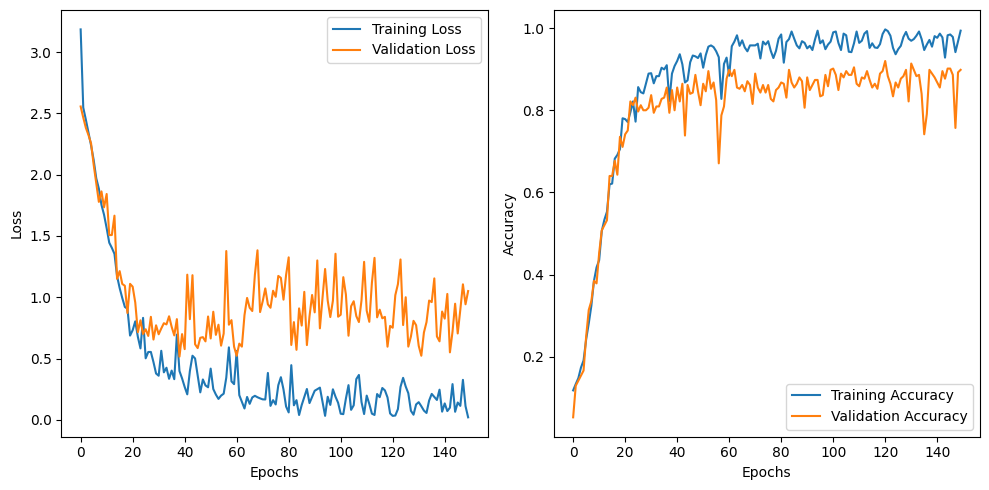

In [43]:
plot_history(ANN_Results)

In [44]:
show_evaluation_parameters(X_test, y_test, ANN_Model, num_labels, encoder)

Accuracy score :  0.92
Precision score:  0.9239525551557908
Recall score   :  0.92
F1 Score       :  0.9198370288459273

--------------------------------------------

              precision    recall  f1-score   support

    barishal       0.93      0.93      0.93        29
      bogura       1.00      0.96      0.98        24
  chottogram       0.91      0.93      0.92        42
    kurigram       1.00      1.00      1.00        15
   madaripur       0.91      1.00      0.95        21
 maymenshing       1.00      1.00      1.00        18
    noakhali       0.95      0.85      0.90        41
       pabna       0.77      0.92      0.84        25
 puran dhaka       0.94      0.94      0.94        18
    rajshahi       0.91      0.74      0.82        27
   shatkhira       1.00      1.00      1.00         4
      sylhet       0.87      0.95      0.91        42
  thakurgaon       1.00      0.89      0.94        19

    accuracy                           0.92       325
   macro avg       0.

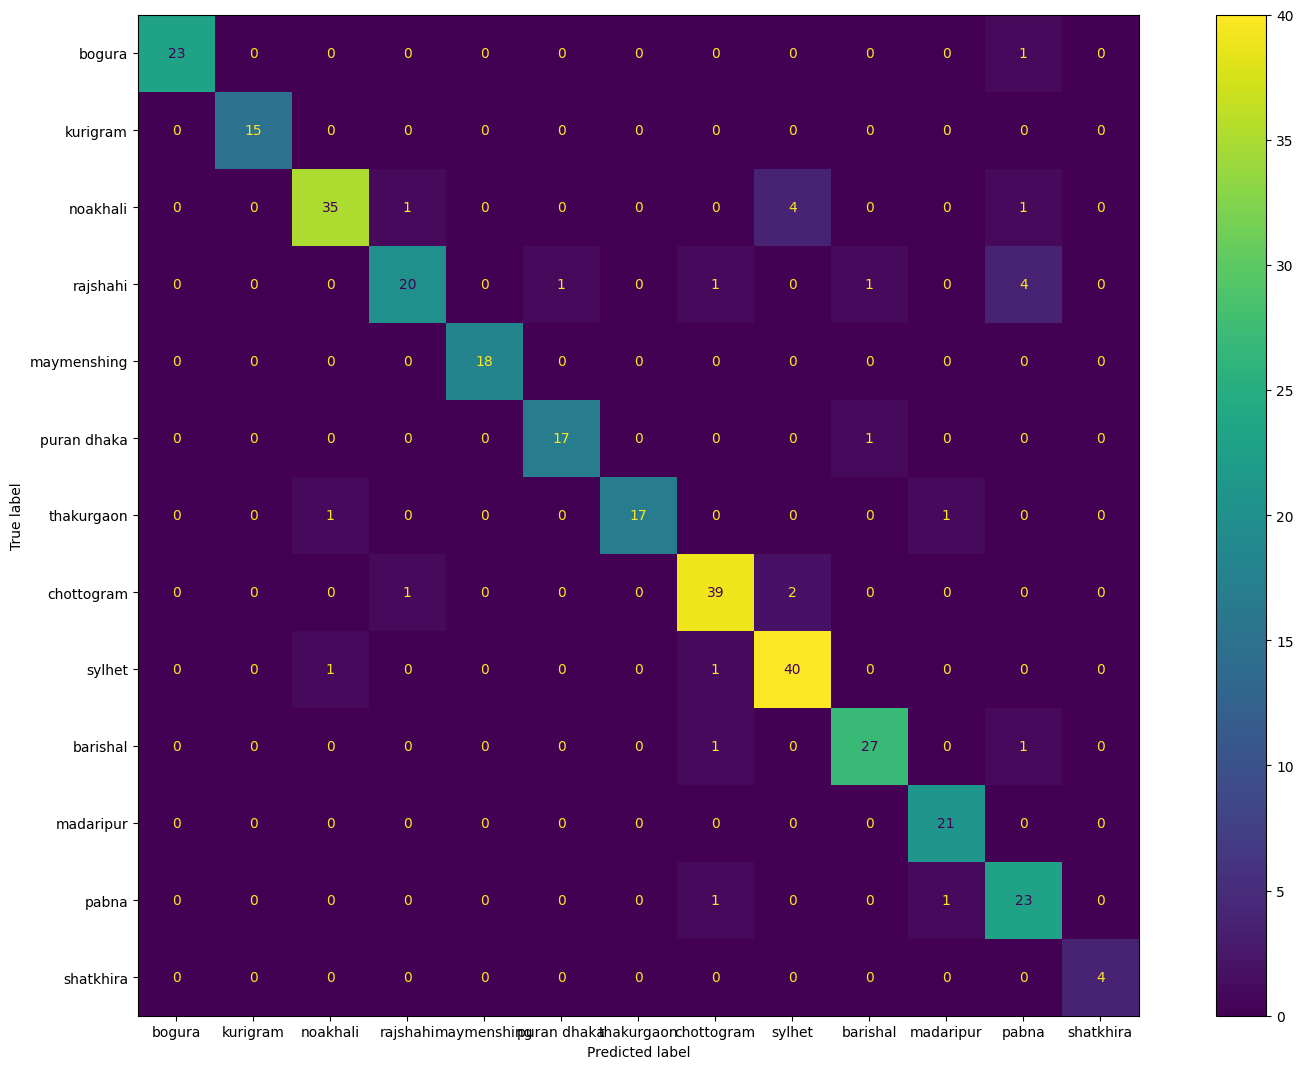

In [45]:
show_confusion_matrix(X_test, y_test, ANN_Model, num_labels, encoder)

## Performance on validation data

In [46]:
show_evaluation_parameters(X_valid, y_valid, ANN_Model, num_labels, encoder)

Accuracy score :  0.9261538461538461
Precision score:  0.9293448925095061
Recall score   :  0.9261538461538461
F1 Score       :  0.9260832791094948

--------------------------------------------

              precision    recall  f1-score   support

    barishal       1.00      0.95      0.98        22
      bogura       1.00      1.00      1.00        19
  chottogram       0.89      0.89      0.89        35
    kurigram       1.00      0.94      0.97        16
   madaripur       1.00      1.00      1.00        15
 maymenshing       0.97      1.00      0.99        34
    noakhali       0.96      0.96      0.96        47
       pabna       0.89      0.76      0.82        33
 puran dhaka       0.96      0.96      0.96        24
    rajshahi       0.84      0.80      0.82        20
   shatkhira       1.00      1.00      1.00         8
      sylhet       0.79      0.95      0.86        39
  thakurgaon       1.00      0.92      0.96        13

    accuracy                           0.93    

## Saving and loading trained model

In [ ]:
# saving the model
ANN_Model.save('/content/drive/MyDrive/Colab Notebooks/Accent Classification/Saved Models/ANN_Model_val_acc_93%.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# loading the model
loaded_ann_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Accent Classification/Saved Models/ANN_Model_val_acc_93%.h5')

In [ ]:
result = loaded_ann_model.evaluate(X_test, y_test, verbose=0)
print(result[1])

0.9281768202781677


# Building CNN1D model

In [ ]:
CNN1D_Model = Sequential()
CNN1D_Model.add(Conv1D(256, 5, strides=1, padding="same", activation="relu", input_shape=(X_train.shape[1], 1),))
CNN1D_Model.add(BatchNormalization())
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Conv1D(256, 5, strides=1, padding="same", activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Conv1D(128, 5, strides=1, padding="same", activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Conv1D(64, 5, strides=1, padding="same", activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Flatten())
CNN1D_Model.add(Dense(units=1024, activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(Dense(units=num_labels, activation="softmax"))

In [ ]:
CNN1D_Model.compile(optimizer="adam",
                    loss="categorical_crossentropy",
                    metrics=["accuracy"])

In [ ]:
CNN1D_Results = CNN1D_Model.fit(X_train,
                                y_train,
                                batch_size=5,
                                epochs=250,
                                validation_data=(X_test, y_test))

Epoch 1/250
195/195 [==============================] - 11s 10ms/step - loss: 2.6055 - accuracy: 0.1867 - val_loss: 2.4015 - val_accuracy: 0.2277
Epoch 2/250
195/195 [==============================] - 1s 6ms/step - loss: 2.3384 - accuracy: 0.1713 - val_loss: 2.2980 - val_accuracy: 0.1938
Epoch 3/250
195/195 [==============================] - 1s 7ms/step - loss: 2.2349 - accuracy: 0.2379 - val_loss: 2.3164 - val_accuracy: 0.2554
Epoch 4/250
195/195 [==============================] - 1s 7ms/step - loss: 2.1794 - accuracy: 0.2636 - val_loss: 2.1552 - val_accuracy: 0.2431
Epoch 5/250
195/195 [==============================] - 1s 7ms/step - loss: 2.0839 - accuracy: 0.2933 - val_loss: 2.0878 - val_accuracy: 0.2892
Epoch 6/250
195/195 [==============================] - 1s 6ms/step - loss: 2.0269 - accuracy: 0.3149 - val_loss: 2.0288 - val_accuracy: 0.3169
Epoch 7/250
195/195 [==============================] - 1s 6ms/step - loss: 2.0027 - accuracy: 0.3067 - val_loss: 2.0728 - val_accuracy: 0.37

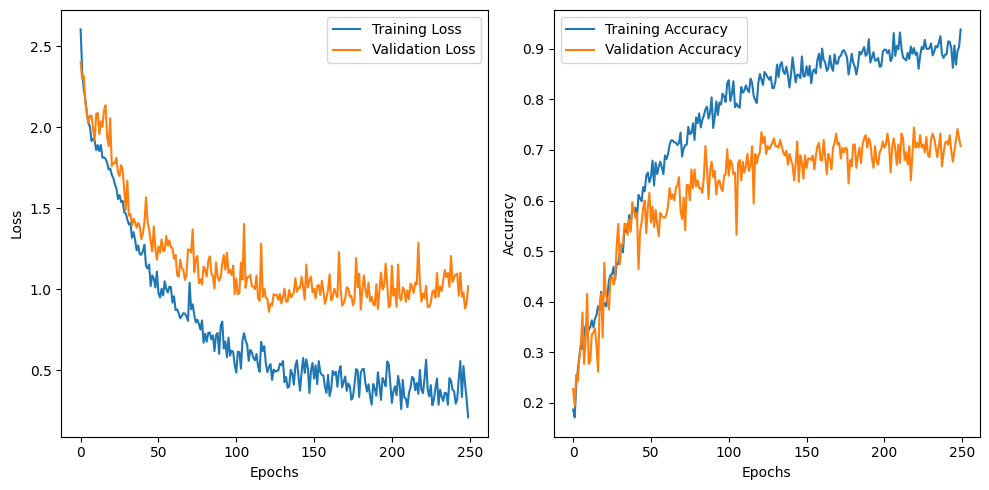

In [ ]:
plot_history(CNN1D_Results)

In [ ]:
show_evaluation_parameters(X_test, y_test, CNN1D_Model, num_labels, encoder)

Accuracy score :  0.7076923076923077
Precision score:  0.7652098902269775
Recall score   :  0.7076923076923077
F1 Score       :  0.7222844664223986

--------------------------------------------

              precision    recall  f1-score   support

    barishal       0.95      0.72      0.82        29
      bogura       0.90      0.79      0.84        24
  chottogram       0.86      0.60      0.70        42
    kurigram       0.92      0.80      0.86        15
   madaripur       1.00      0.81      0.89        21
 maymenshing       0.89      0.89      0.89        18
    noakhali       0.70      0.73      0.71        41
       pabna       0.32      0.64      0.43        25
 puran dhaka       0.87      0.72      0.79        18
    rajshahi       0.76      0.59      0.67        27
   shatkhira       0.50      0.50      0.50         4
      sylhet       0.57      0.79      0.66        42
  thakurgaon       0.71      0.53      0.61        19

    accuracy                           0.71    

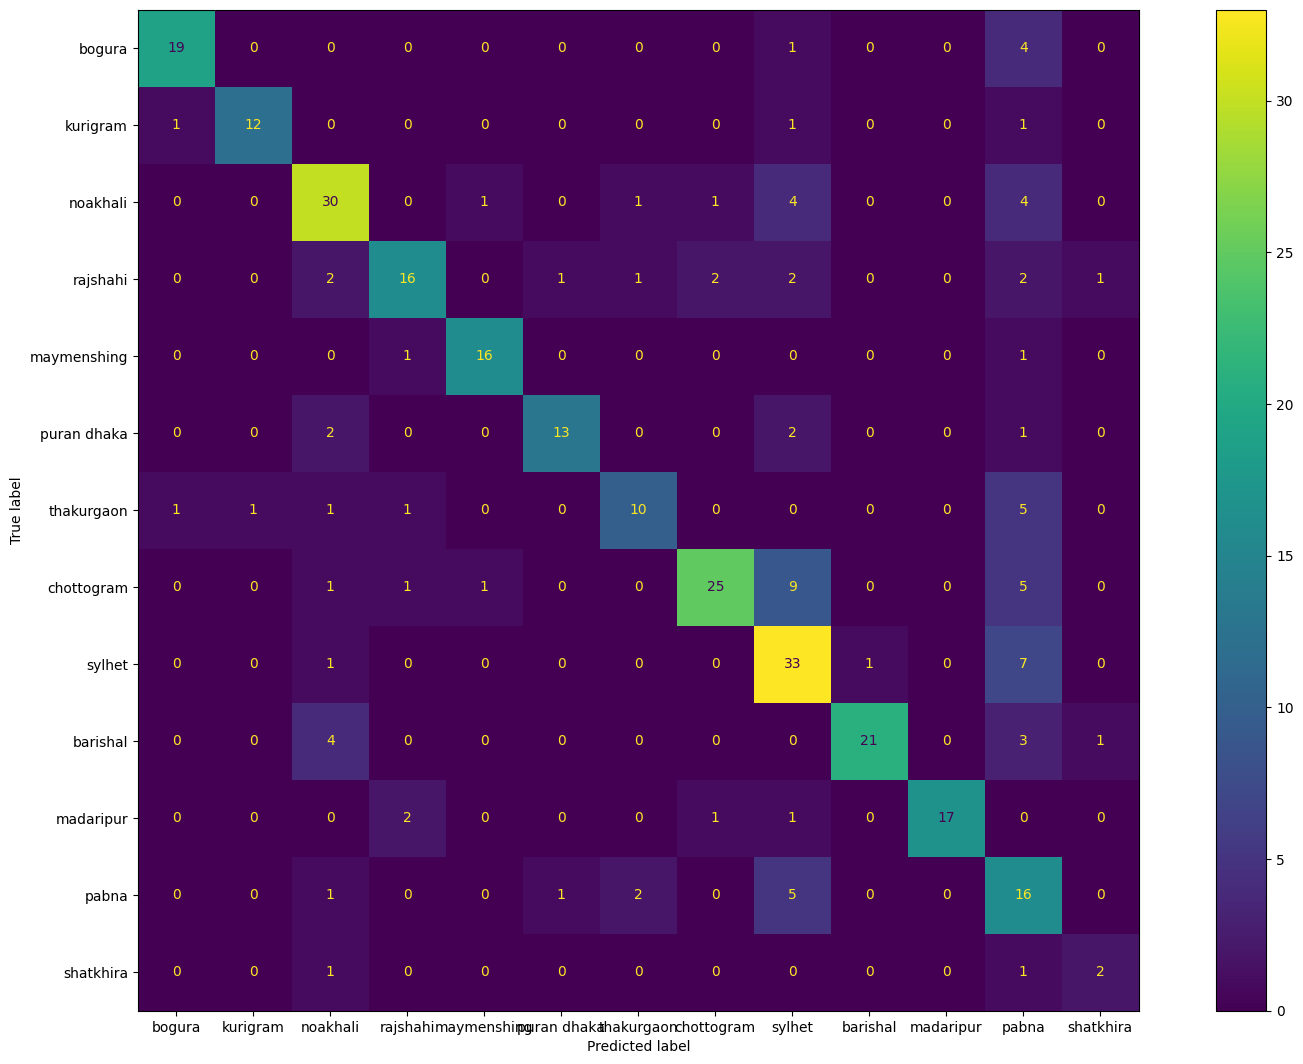

In [ ]:
show_confusion_matrix(X_test, y_test, CNN1D_Model, num_labels, encoder)

## Performance on validation data

In [ ]:
show_evaluation_parameters(X_valid, y_valid, CNN1D_Model, num_labels, encoder)

Accuracy score :  0.7569230769230769
Precision score:  0.7828055012244766
Recall score   :  0.7569230769230769
F1 Score       :  0.7650610410615484

--------------------------------------------

              precision    recall  f1-score   support

    barishal       1.00      0.77      0.87        22
      bogura       0.94      0.89      0.92        19
  chottogram       0.77      0.66      0.71        35
    kurigram       1.00      0.88      0.93        16
   madaripur       0.93      0.93      0.93        15
 maymenshing       0.97      0.88      0.92        34
    noakhali       0.75      0.77      0.76        47
       pabna       0.44      0.67      0.53        33
 puran dhaka       0.71      0.71      0.71        24
    rajshahi       0.76      0.65      0.70        20
   shatkhira       1.00      0.88      0.93         8
      sylhet       0.67      0.72      0.69        39
  thakurgaon       0.67      0.62      0.64        13

    accuracy                           0.76    

# Building CNN2D model

In [ ]:
# reshaping features to pass into the model
X_train_reshaped = X_train.reshape(X_train.shape[0], 16, 8, 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], 16, 8, 1)
X_valid_reshaped = X_valid.reshape(X_valid.shape[0], 16, 8, 1)

In [ ]:
CNN2D_Model = Sequential()
CNN2D_Model.add(Conv2D(64, (3, 3), padding="same", activation="tanh", input_shape=(16, 8, 1)))
CNN2D_Model.add(MaxPool2D(pool_size=(2, 2)))
CNN2D_Model.add(Conv2D(128, (3, 3), padding="same", activation="tanh"))
CNN2D_Model.add(MaxPool2D(pool_size=(2, 2)))
CNN2D_Model.add(Dropout(0.1))
CNN2D_Model.add(Flatten())
CNN2D_Model.add(Dense(256, activation="tanh"))
CNN2D_Model.add(Dense(num_labels, activation="softmax"))

In [ ]:
CNN2D_Model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
                    loss="categorical_crossentropy",
                    metrics=["accuracy"])

In [ ]:
CNN2D_Results = CNN2D_Model.fit(X_train_reshaped,
                                y_train,
                                batch_size=5,
                                epochs=13,
                                validation_data=(X_test_reshaped, y_test))

Epoch 1/13
195/195 [==============================] - 3s 5ms/step - loss: 1.8999 - accuracy: 0.4144 - val_loss: 1.2129 - val_accuracy: 0.6523
Epoch 2/13
195/195 [==============================] - 1s 4ms/step - loss: 1.0620 - accuracy: 0.6718 - val_loss: 1.0610 - val_accuracy: 0.6738
Epoch 3/13
195/195 [==============================] - 1s 4ms/step - loss: 0.7043 - accuracy: 0.7651 - val_loss: 0.8637 - val_accuracy: 0.7385
Epoch 4/13
195/195 [==============================] - 1s 4ms/step - loss: 0.5341 - accuracy: 0.8215 - val_loss: 0.8733 - val_accuracy: 0.7477
Epoch 5/13
195/195 [==============================] - 1s 4ms/step - loss: 0.3511 - accuracy: 0.8892 - val_loss: 0.8156 - val_accuracy: 0.7723
Epoch 6/13
195/195 [==============================] - 1s 4ms/step - loss: 0.2957 - accuracy: 0.9097 - val_loss: 0.8226 - val_accuracy: 0.7877
Epoch 7/13
195/195 [==============================] - 1s 4ms/step - loss: 0.1192 - accuracy: 0.9662 - val_loss: 0.6584 - val_accuracy: 0.8308
Epoch 

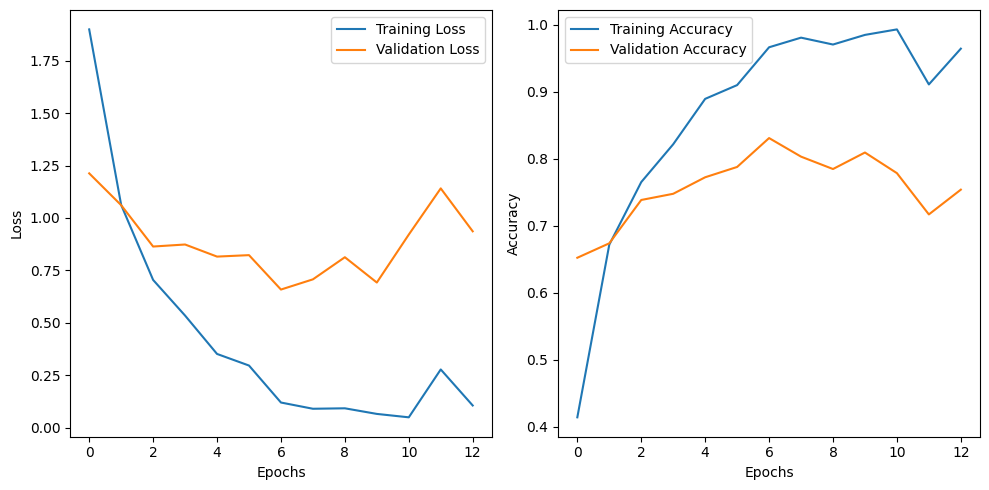

In [ ]:
plot_history(CNN2D_Results)

In [ ]:
show_evaluation_parameters(X_test_reshaped, y_test, CNN2D_Model, num_labels, encoder)

Accuracy score :  0.7538461538461538
Precision score:  0.7941749860963908
Recall score   :  0.7538461538461538
F1 Score       :  0.7553904776970704

--------------------------------------------

              precision    recall  f1-score   support

    barishal       0.87      0.69      0.77        29
      bogura       0.81      0.88      0.84        24
  chottogram       0.82      0.79      0.80        42
    kurigram       0.94      1.00      0.97        15
   madaripur       1.00      0.86      0.92        21
 maymenshing       0.86      1.00      0.92        18
    noakhali       0.71      0.73      0.72        41
       pabna       0.86      0.48      0.62        25
 puran dhaka       0.67      0.78      0.72        18
    rajshahi       0.43      0.89      0.58        27
   shatkhira       0.50      0.25      0.33         4
      sylhet       0.84      0.74      0.78        42
  thakurgaon       0.89      0.42      0.57        19

    accuracy                           0.75    

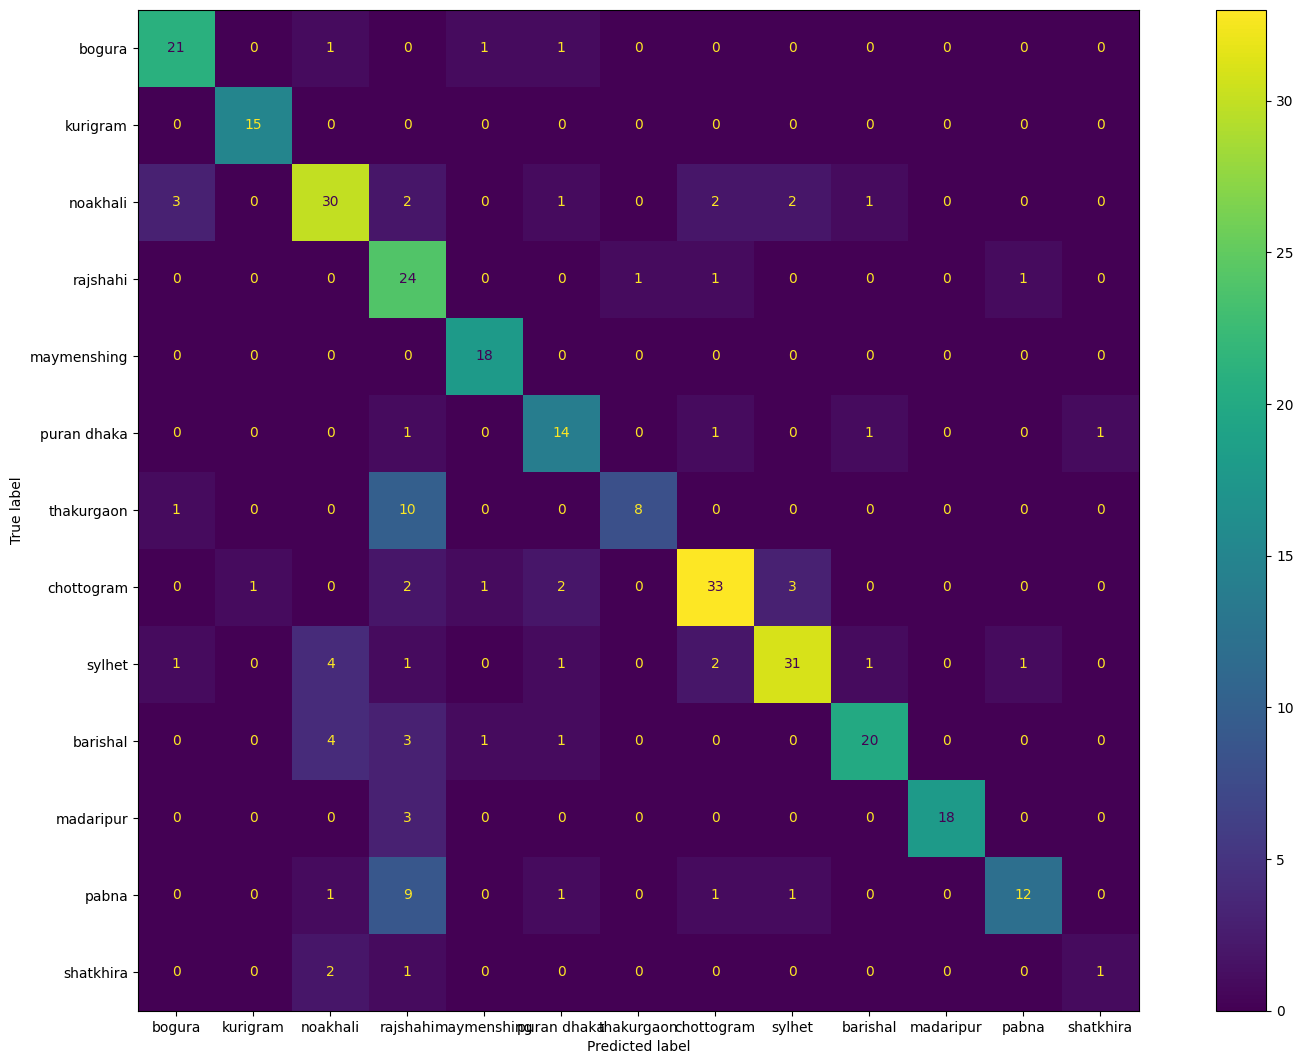

In [ ]:
show_confusion_matrix(X_test_reshaped, y_test, CNN2D_Model, num_labels, encoder)

## Performance on validation data

In [ ]:
show_evaluation_parameters(X_valid_reshaped, y_valid, CNN2D_Model, num_labels, encoder)

Accuracy score :  0.8061538461538461
Precision score:  0.8478850200998265
Recall score   :  0.8061538461538461
F1 Score       :  0.8097444931057283

--------------------------------------------

              precision    recall  f1-score   support

    barishal       0.95      0.95      0.95        22
      bogura       0.89      0.84      0.86        19
  chottogram       0.79      0.77      0.78        35
    kurigram       0.93      0.88      0.90        16
   madaripur       1.00      0.87      0.93        15
 maymenshing       0.97      0.94      0.96        34
    noakhali       0.89      0.83      0.86        47
       pabna       0.81      0.39      0.53        33
 puran dhaka       0.91      0.83      0.87        24
    rajshahi       0.39      0.90      0.55        20
   shatkhira       1.00      0.50      0.67         8
      sylhet       0.74      0.90      0.81        39
  thakurgaon       0.91      0.77      0.83        13

    accuracy                           0.81    

# Building LSTM model

In [ ]:
from tensorflow.keras.layers import LSTM

In [ ]:
lstm_model = tf.keras.Sequential()
# first layer after input layer
lstm_model.add(LSTM(128,input_shape=(128, 1)))
lstm_model.add(Dropout(0.2))
# second layer
lstm_model.add(Dense(100, activation='relu'))
# third layer
lstm_model.add(Dense(100, activation='relu'))
lstm_model.add(Dropout(0.2))
# forth layer
lstm_model.add(Dense(100, activation='relu'))
lstm_model.add(Dropout(0.2))
# output layer
lstm_model.add(Dense(num_labels, activation='softmax'))
lstm_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_20 (Dropout)        (None, 128)               0         
                                                                 
 dense_24 (Dense)            (None, 100)               12900     
                                                                 
 dense_25 (Dense)            (None, 100)               10100     
                                                                 
 dropout_21 (Dropout)        (None, 100)               0         
                                                                 
 dense_26 (Dense)            (None, 100)               10100     
                                                                 
 dropout_22 (Dropout)        (None, 100)              

In [ ]:
lstm_model.compile(optimizer='adam',
                   loss='CategoricalCrossentropy',
                   metrics=['accuracy'])

In [ ]:
lstm_history = lstm_model.fit(X_train,
                              y_train,
                              epochs=50,
                              batch_size=5,
                              validation_data=(X_test, y_test),
                              shuffle=False)

Epoch 1/50
195/195 [==============================] - 5s 11ms/step - loss: 2.4529 - accuracy: 0.1497 - val_loss: 2.3744 - val_accuracy: 0.1723
Epoch 2/50
195/195 [==============================] - 2s 11ms/step - loss: 2.3018 - accuracy: 0.1959 - val_loss: 2.2074 - val_accuracy: 0.2431
Epoch 3/50
195/195 [==============================] - 2s 11ms/step - loss: 2.2380 - accuracy: 0.2318 - val_loss: 2.1752 - val_accuracy: 0.2185
Epoch 4/50
195/195 [==============================] - 2s 9ms/step - loss: 2.1867 - accuracy: 0.2236 - val_loss: 2.1271 - val_accuracy: 0.2246
Epoch 5/50
195/195 [==============================] - 2s 9ms/step - loss: 2.1549 - accuracy: 0.2267 - val_loss: 2.1058 - val_accuracy: 0.2554
Epoch 6/50
195/195 [==============================] - 2s 9ms/step - loss: 2.1547 - accuracy: 0.2656 - val_loss: 2.1202 - val_accuracy: 0.2523
Epoch 7/50
195/195 [==============================] - 2s 9ms/step - loss: 2.0906 - accuracy: 0.2749 - val_loss: 2.1045 - val_accuracy: 0.3015
Epo

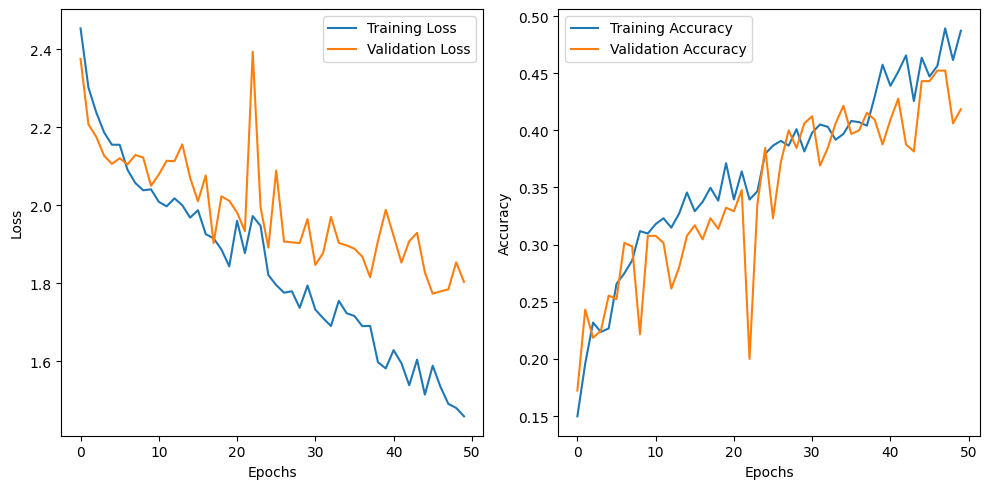

In [ ]:
plot_history(lstm_history)

In [ ]:
show_evaluation_parameters(X_test, y_test, lstm_model, num_labels, encoder)

Accuracy score :  0.41846153846153844
Precision score:  0.49156235300510537
Recall score   :  0.41846153846153844
F1 Score       :  0.422551952342481

--------------------------------------------

              precision    recall  f1-score   support

    barishal       0.50      0.41      0.45        29
      bogura       0.86      0.50      0.63        24
  chottogram       0.76      0.52      0.62        42
    kurigram       0.24      0.60      0.34        15
   madaripur       0.33      0.71      0.45        21
 maymenshing       1.00      0.44      0.62        18
    noakhali       0.43      0.51      0.47        41
       pabna       0.17      0.16      0.16        25
 puran dhaka       0.10      0.11      0.11        18
    rajshahi       0.38      0.59      0.46        27
   shatkhira       0.20      0.25      0.22         4
      sylhet       0.62      0.31      0.41        42
  thakurgaon       0.20      0.05      0.08        19

    accuracy                           0.42  

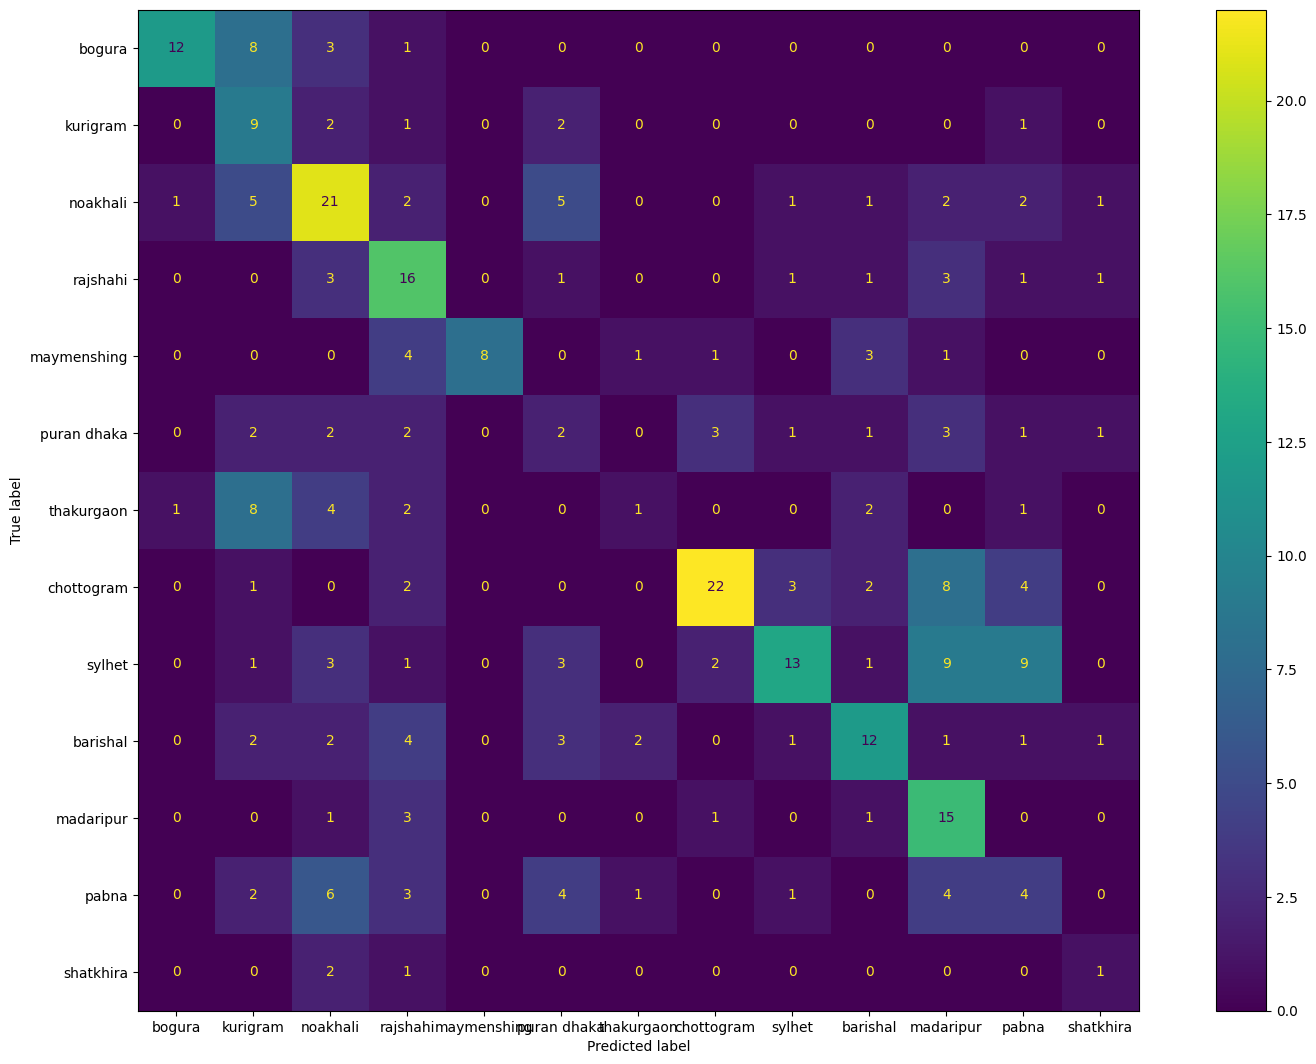

In [ ]:
show_confusion_matrix(X_test, y_test, lstm_model, num_labels, encoder)

## Performance on validation data

In [ ]:
show_evaluation_parameters(X_valid, y_valid, lstm_model, num_labels, encoder)

Accuracy score :  0.44
Precision score:  0.5002529787692491
Recall score   :  0.44
F1 Score       :  0.44263808509589214

--------------------------------------------

              precision    recall  f1-score   support

    barishal       0.55      0.50      0.52        22
      bogura       0.71      0.63      0.67        19
  chottogram       0.57      0.57      0.57        35
    kurigram       0.33      0.75      0.46        16
   madaripur       0.17      0.53      0.26        15
 maymenshing       0.87      0.38      0.53        34
    noakhali       0.48      0.49      0.48        47
       pabna       0.33      0.21      0.26        33
 puran dhaka       0.14      0.08      0.11        24
    rajshahi       0.37      0.65      0.47        20
   shatkhira       0.50      0.38      0.43         8
      sylhet       0.71      0.44      0.54        39
  thakurgaon       0.29      0.15      0.20        13

    accuracy                           0.44       325
   macro avg       0